## Initial setup

In [1]:
import Drone
from configurations import defaultConfig 
import numpy as np
from ConvexMotionPlanning import TrajGen 
from plottingFunctions import state_plots_command, open_loop_plots


In [2]:
# Drone instantiation
config = defaultConfig()
config.numObstacles = 5
drone = Drone.Drone(config, config)

# Parameters
thrustCommandVal = 4.3
refStates = drone.coherentCommand(thrustCommandVal,0/180*np.pi)
controlRef = (thrustCommandVal, drone.elevatorFromAlpha(refStates[1]-refStates[3]))
iterations = 1000
iter = 0
pathDist = 100
stateRef = np.hstack(([0,50], refStates))
drone.reset(stateRef)

# Data
traj = np.zeros((7,iterations))
elvActual = np.zeros(iterations)
thrustCommand = np.zeros(iterations)+thrustCommandVal
stateCommand = drone.coherentCommand(thrustCommand[0],0/180*np.pi)
elivCommandRef = drone.elevatorFromAlpha(stateCommand[1]-stateCommand[3])
elivCommand = np.zeros(iterations) + elivCommandRef
xCommand = np.zeros(iterations)
yCommand = np.zeros(iterations)
refCommand = np.zeros((iterations, 4))
refCommand[0] = refStates

# Main loop
for iter in range(0, iterations):
    action = [thrustCommand[iter], elivCommand[iter], refCommand[iter, :]] 
    observation, grid, reward, terminated = drone.step(action)
    traj[:,iter] = np.hstack((drone.plant.state,drone.plant.time))
    elvActual[iter] = drone.delta_e_actual
    if(iter%pathDist == 0):
        thrustCommand, elivCommand, xCommand, yCommand, refCommand = TrajGen(drone, grid, thrustCommand, elivCommand, xCommand, yCommand, refStates, refCommand, thrustCommandVal,elivCommandRef, iterations, iter)
    if(terminated):
        break

<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast


(1000,)


/home/matthew/Documents/Flappy-Junco/plottingFunctions.py:78: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


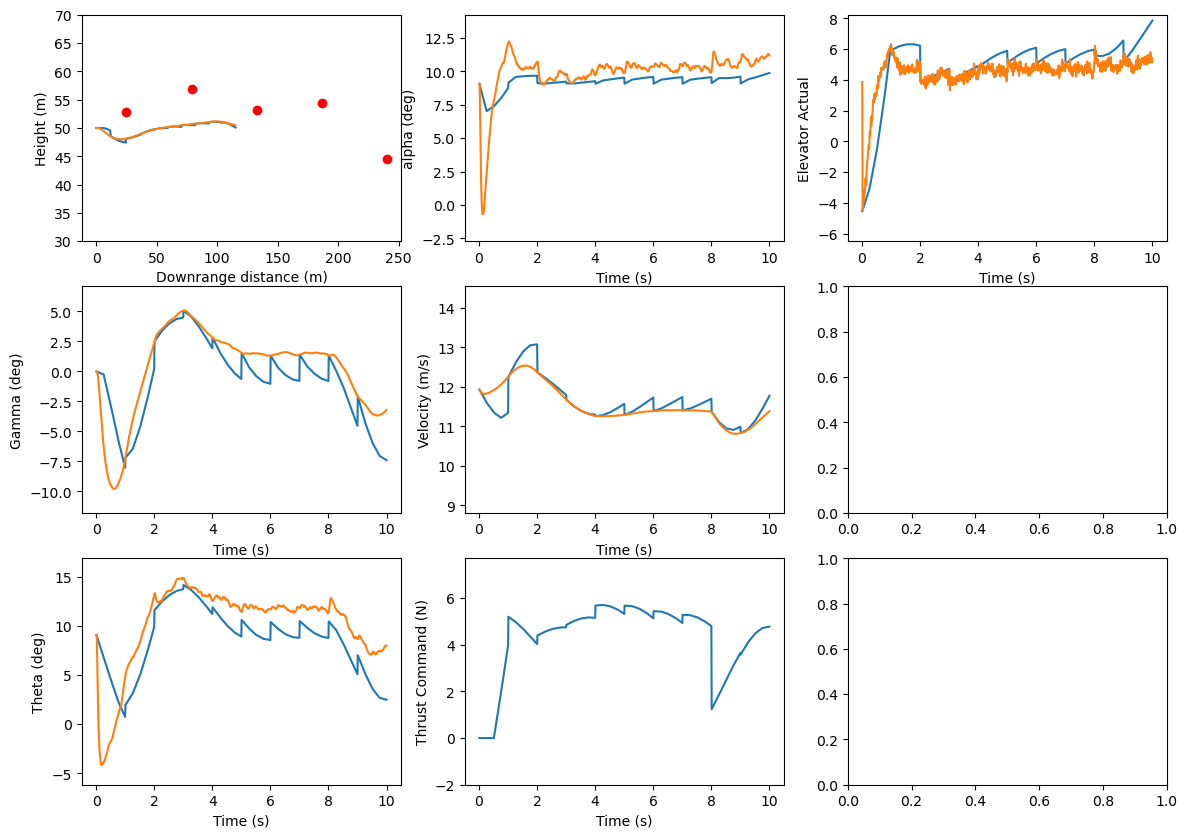

In [3]:
import importlib
import plottingFunctions
importlib.reload(plottingFunctions)
plottingFunctions.state_plots_command(traj,thrustCommand,xCommand, yCommand, elivCommand,elvActual, refCommand, drone)

In [4]:
print(elivCommand.shape)

(1000,)


ValueError: x and y must have same first dimension, but have shapes (1397,) and (1000,)

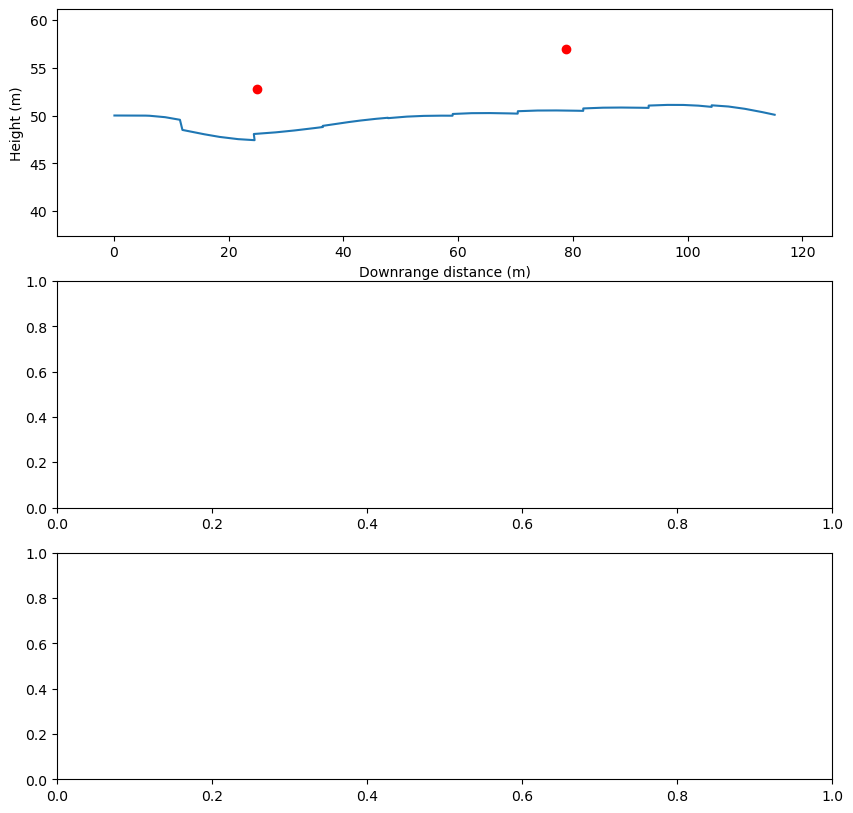

In [5]:
tEnd = 450
timeMulti = 2
open_loop_plots(0, iter+tEnd-timeMulti-50,xCommand, yCommand,thrustCommand, elivCommand, drone)

In [ ]:
import Drone
from configurations import defaultConfig 
import numpy as np
from plottingFunctions import open_loop_plots, plot_rrt_lines_flipped
import importlib
import matplotlib as mpl
import matplotlib.pyplot as plt
from rrtplanner import RRTStar, plot_rrt_lines, plot_path, plot_og, plot_start_goal
import ConvexMotionPlanning
import copy

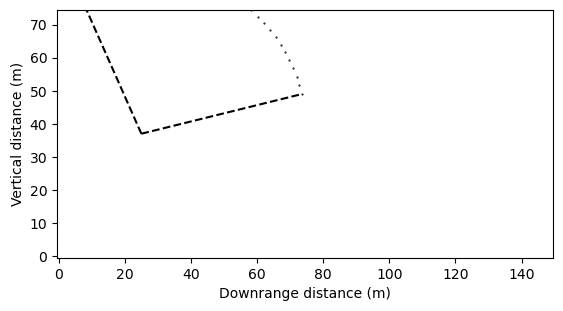

In [ ]:
# random data
fig, ax = plt.subplots()

# define the colors
cmap = mpl.colors.ListedColormap(['w', 'k'])

# create a normalize object the describes the limits of
# each color
bounds = [0., 0.5, 1.]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

# plot it
x = drone.ogOrigin[0]
z = drone.ogOrigin[1]
theta = drone.plant.state[3]
beam = drone.lidar_range
angle = drone.lidar_angle
res = drone.lidar_res
ax.plot([x,x+beam*np.cos(theta+angle/2)],[z,z+beam*np.sin(theta+angle/2)],'k--')
ax.plot([x,x+beam*np.cos(theta-angle/2)],[z,z+beam*np.sin(theta-angle/2)],'k--')
a = np.linspace(-angle/2,angle/2,int(res/3))
xs = x+beam*np.cos(theta+a)
zs = z+beam*np.sin(theta+a)
ax.plot(xs,zs,'k.',markersize=1)

ax.imshow(grid, interpolation='none', cmap=cmap, norm=norm)
ax.set_xlabel("Downrange distance (m)")
ax.set_ylabel("Vertical distance (m)")
plt.gca().invert_yaxis()


Text(0, 0.5, 'Vertical distance in OG (m)')

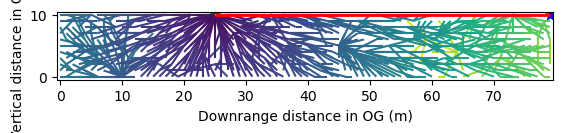

In [ ]:
midpoint = drone.ogOrigin[1]
offset = 10
lookAhead = 54
orignX = drone.ogOrigin[0]
xstart = np.array([offset, orignX]) 
xgoal = np.array([offset, orignX+lookAhead])
n = 3000
r_rewire = 5
rrts = RRTStar(grid[midpoint-offset:midpoint+1, 0:80], n, r_rewire, pbar = False) 
T, gv = rrts.plan(xstart, xgoal)
path = rrts.route2gv(T, gv)
path_pts = rrts.vertices_as_ndarray(T, path)
tEnd = 450

fig = plt.figure()
ax = fig.add_subplot()

#these functions alter ax in-place.
plot_og(ax, grid[midpoint-offset:midpoint+1, 0:80].T)
plot_start_goal(ax, np.flip(xstart, 0), np.flip(xgoal, 0))
plot_rrt_lines_flipped(ax, T)
plot_path(ax, np.flip(path_pts,2))
Ttemp = copy.deepcopy(T)
ax.set_xlabel("Downrange distance in OG (m)")
ax.set_ylabel("Vertical distance in OG (m)")

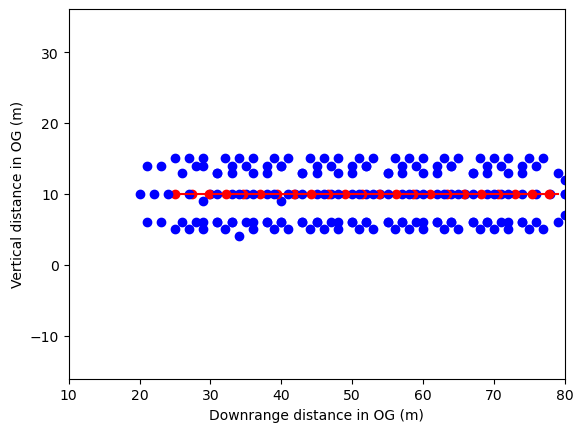

In [ ]:
numDirections = 8
directs = ConvexMotionPlanning.generateDirections(numDirections)

fig, ax = plt.subplots()
#ax.scatter(drone.objects[0,:],drone.objects[1,:], color = "red" )-
referencePointsPlot, referenceVelsPlot= ConvexMotionPlanning.calculateReferencePoints(tEnd+1, path_pts)

xRefsToPlot = list(zip(*referencePointsPlot))[0]
yRefsToPlot = list(zip(*referencePointsPlot))[1]

plt.plot(yRefsToPlot, xRefsToPlot, color = 'red')
indexes = range(len(xRefsToPlot))
indexes = indexes[0::20]
for i in indexes:
    cords = ConvexMotionPlanning.searchFromCord([xRefsToPlot[i], yRefsToPlot[i]], directs, grid[midpoint-offset:midpoint+5, 0:80], limit = 5)
    plt.scatter(cords[:, 1], cords[:, 0], color = 'blue')
    plt.scatter(yRefsToPlot[i], xRefsToPlot[i], color = 'red')
    plt.axis('equal')
plot_og(ax, grid[midpoint-offset:midpoint+3, 0:80].T)
ax.set_xlabel("Downrange distance in OG (m)")
ax.set_ylabel("Vertical distance in OG (m)")
ax.set_ylim(ymin=0.0, ymax=20)
ax.set_xlim(xmin=10, xmax=80)

plt.show()


In [ ]:
import math
thrustCommandVal = 4.4
refStates = drone.coherentCommand(thrustCommandVal,0/180*np.pi)
controlRef = (thrustCommandVal, drone.elevatorFromAlpha(refStates[1]-refStates[3]))

iterations = 2000
iter = 0
thrustCommand = np.zeros(iterations)+thrustCommandVal
stateCommand = drone.coherentCommand(thrustCommand[0],0/180*np.pi)
elivCommandRef = drone.elevatorFromAlpha(stateCommand[1]-stateCommand[3])
elivCommand = np.zeros(iterations) + elivCommandRef
xCommand = np.zeros(iterations)
yCommand = np.zeros(iterations)
refCommand = np.zeros((iterations, 4))
timeMulti = 10

referencePoints, referenceVels = ConvexMotionPlanning.calculateReferencePoints(math.floor(tEnd/timeMulti)+1, path_pts)
referencePointsDyn, referenceVelsDyn = ConvexMotionPlanning.calculateReferencePoints(math.floor(tEnd/timeMulti)+1, path_pts)
for i in range(len(referencePointsDyn)):
    referencePointsDyn[i][0] = referencePointsDyn[i][0]-refStates[0]*np.sin(refStates[3])*i*drone.dt*timeMulti-offset
    referencePointsDyn[i][1] = referencePointsDyn[i][1]-refStates[0]*np.cos(refStates[3])*i*drone.dt*timeMulti-orignX
Acts, Bcts = drone.calculateCTSABMatrix(refStates, controlRef)
Aopt = np.eye(Acts.shape[0]+2)
#A = Aopt + env.calculateANumerical(stateRefFull, controlRef, env.rhoNom, step=10**-5)*env.dt
Aopt[0, 2] = drone.dt*timeMulti
Aopt[1, 5] = refStates[0]*drone.dt*timeMulti
Aopt[2:,2:] = Aopt[2:,2:]+Acts*drone.dt*timeMulti
Bopt = np.zeros([6,2])
Bopt[2:,0:1] = Bcts*drone.dt*timeMulti
alphaEst = refStates[1] - refStates[3]
Bopt[2, 1] = 1/drone.m*np.cos(alphaEst)*drone.dt*timeMulti
Bopt[5, 1] = 1/drone.m*np.sin(alphaEst)/refStates[0]*drone.dt*timeMulti
xstart = np.concatenate(([0.,0.], np.array(drone.stateEstimate) - np.array(refStates) + np.array([0, 0.01, 0, 0])))
xgoal = np.concatenate(([0.,50 - drone.plant.state[1]], [0.,0.,0.,0.]))
xsol, usol = ConvexMotionPlanning.localTrajOpt(Aopt, Bopt, math.floor(tEnd/timeMulti), grid[midpoint-offset:, 0:80], referencePoints, referencePointsDyn, xstart, xgoal)
for i in range(np.min((tEnd-timeMulti-1, iterations-iter))):
    iDrop = math.floor(i/timeMulti)
    iNext = iDrop+1
    ifrac1 = (timeMulti - i%timeMulti)/timeMulti
    ifrac2 = (i%timeMulti)/timeMulti

    thrustCommand[iter+i] = ifrac1*usol[iDrop][1] + ifrac2*usol[iNext][1]  + thrustCommandVal 
    elivCommand[iter + i] = ifrac1*usol[iDrop][0] + ifrac2*usol[iNext][0] + elivCommandRef
    xCommand[iter+i] = ifrac1*xsol[iDrop][0] + ifrac2*xsol[iNext][0] +refStates[0]*np.cos(0)*i*drone.dt+drone.plant.state[0]
    yCommand[iter+i] = ifrac1*xsol[iDrop][1] + ifrac2*xsol[iNext][1] + refStates[0]*np.sin(0)*i*drone.dt+drone.plant.state[1]
    refCommand[iter+i, :] = ifrac1*xsol[iDrop][2:6].T + ifrac2*xsol[iNext][2:6].T + np.array(refStates)

ValueError: too many values to unpack (expected 2)

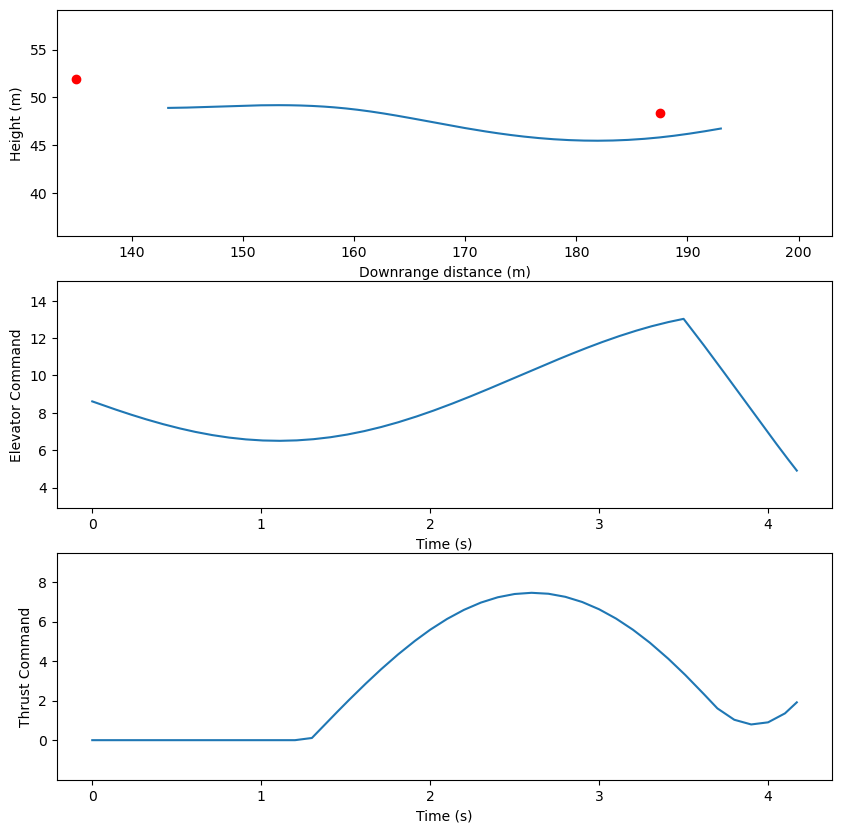

In [ ]:
tEnd = 450
timeMulti = 2
open_loop_plots(iter, iter+tEnd-timeMulti-30,xCommand, yCommand,thrustCommand, elivCommand, drone)